<h1> Load Data into Colab Session

In [0]:
#unzipping here in colab session
#!unzip '/content/drive/My Drive/MonuSeg.zip'

In [263]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [254]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [264]:
#!pip install --ignore-installed --upgrade tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

1.15.2


In [0]:
#Dataset MonuSeg
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

#import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from cyclical_learning_rate import *

<h1> Load Training Data

In [0]:
# Set some parameters
im_width = 256
im_height = 256
depth = 3
#border = 5

In [267]:
# list of names all images in the given path
ids_train = next(os.walk("./Patch_MonuSeg/Training/TissueImages"))[2]
print("No. of images in training set= ", len(ids_train))

# list of names all images in the given path
ids_test = next(os.walk("./Patch_MonuSeg/Test/TissueImages"))[2]
print("No. of images in testing set = ", len(ids_test))

No. of images in training set=  1080
No. of images in testing set =  504


In [0]:
#train
X_train = np.zeros((len(ids_train), im_height, im_width, depth), dtype=np.float32)
y_train = np.zeros((len(ids_train), im_height, im_width, depth), dtype=np.float32)

#test
X_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)
y_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)

In [269]:
#train

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_train), total=len(ids_train)):
    # Load images
    img = load_img("Patch_MonuSeg/Training/TissueImages/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d1 = d[0].split('-')
    id_ = d1[0]+"-"+d1[1]+"-"+d1[2]+"-"+d1[3]+"-"+d1[4]+"-"+d1[5]+"_bin_mask-"+d1[-1]+"."+d[1]
    #print(id_)
    
    # Load masks
    mask = img_to_array(load_img("Patch_MonuSeg/Training/GroundTruth/"+id_))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    X_train[n] = x_img/255.0
    y_train[n] = mask/255.0
    
    
    
#test

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("Patch_MonuSeg/Test/TissueImages/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename masks
    d = id_.split('.')
    d1 = d[0].split('-')
    id_ = d1[0]+"-"+d1[1]+"-"+d1[2]+"-"+d1[3]+"-"+d1[4]+"-"+d1[5]+"_bin_mask-"+d1[-1]+".png"
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("Patch_MonuSeg/Test/GroundTruth/"+id_))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    X_test[n] = x_img/255.0
    y_test[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


<h1> Split data

In [270]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test,
                                        test_size=0.2, random_state=42)

print(len(X_test))
print(len(X_valid))

403
101


<h1> Visualize training data

500
True


Text(0.5, 1.0, 'Mask')

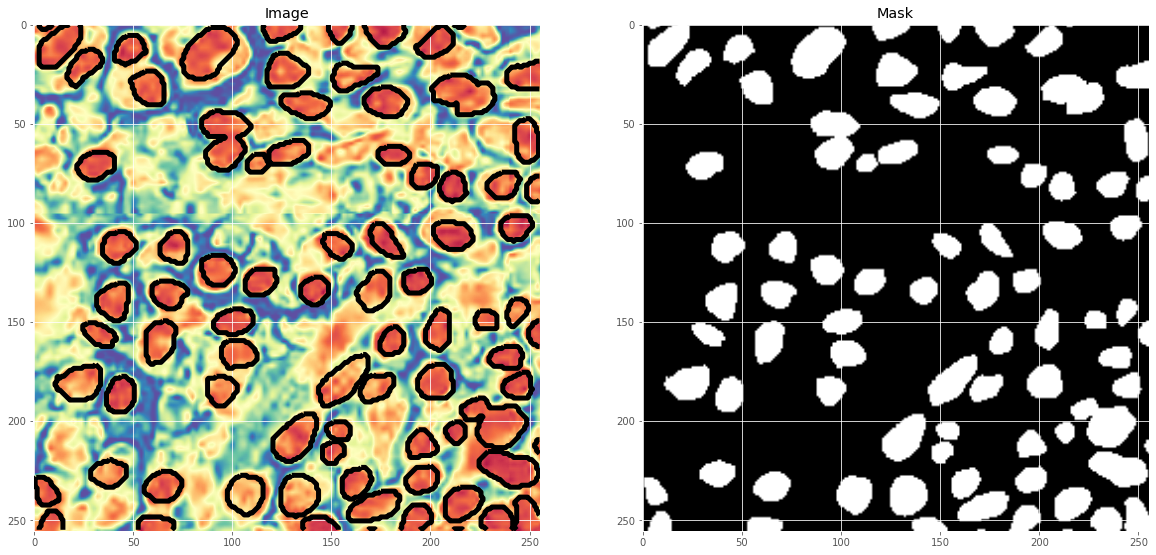

In [271]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
print(ix)
has_mask = y_train[ix].max() > 0 # salt indicator
print(has_mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'Spectral', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix, ..., 0].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(y_train[ix, ..., 0].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')


<h1> Define UNet Model

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.05, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

<h1> Performance Metrices for Model to be evaluated on </h1>

In [0]:
#metrics
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
  
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def _recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def _precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = _precision(y_true, y_pred)
    recall = _recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
input_img = Input((im_height,im_width , depth), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy",dice_coef,f1_score])

#loss="binary_crossentropy"

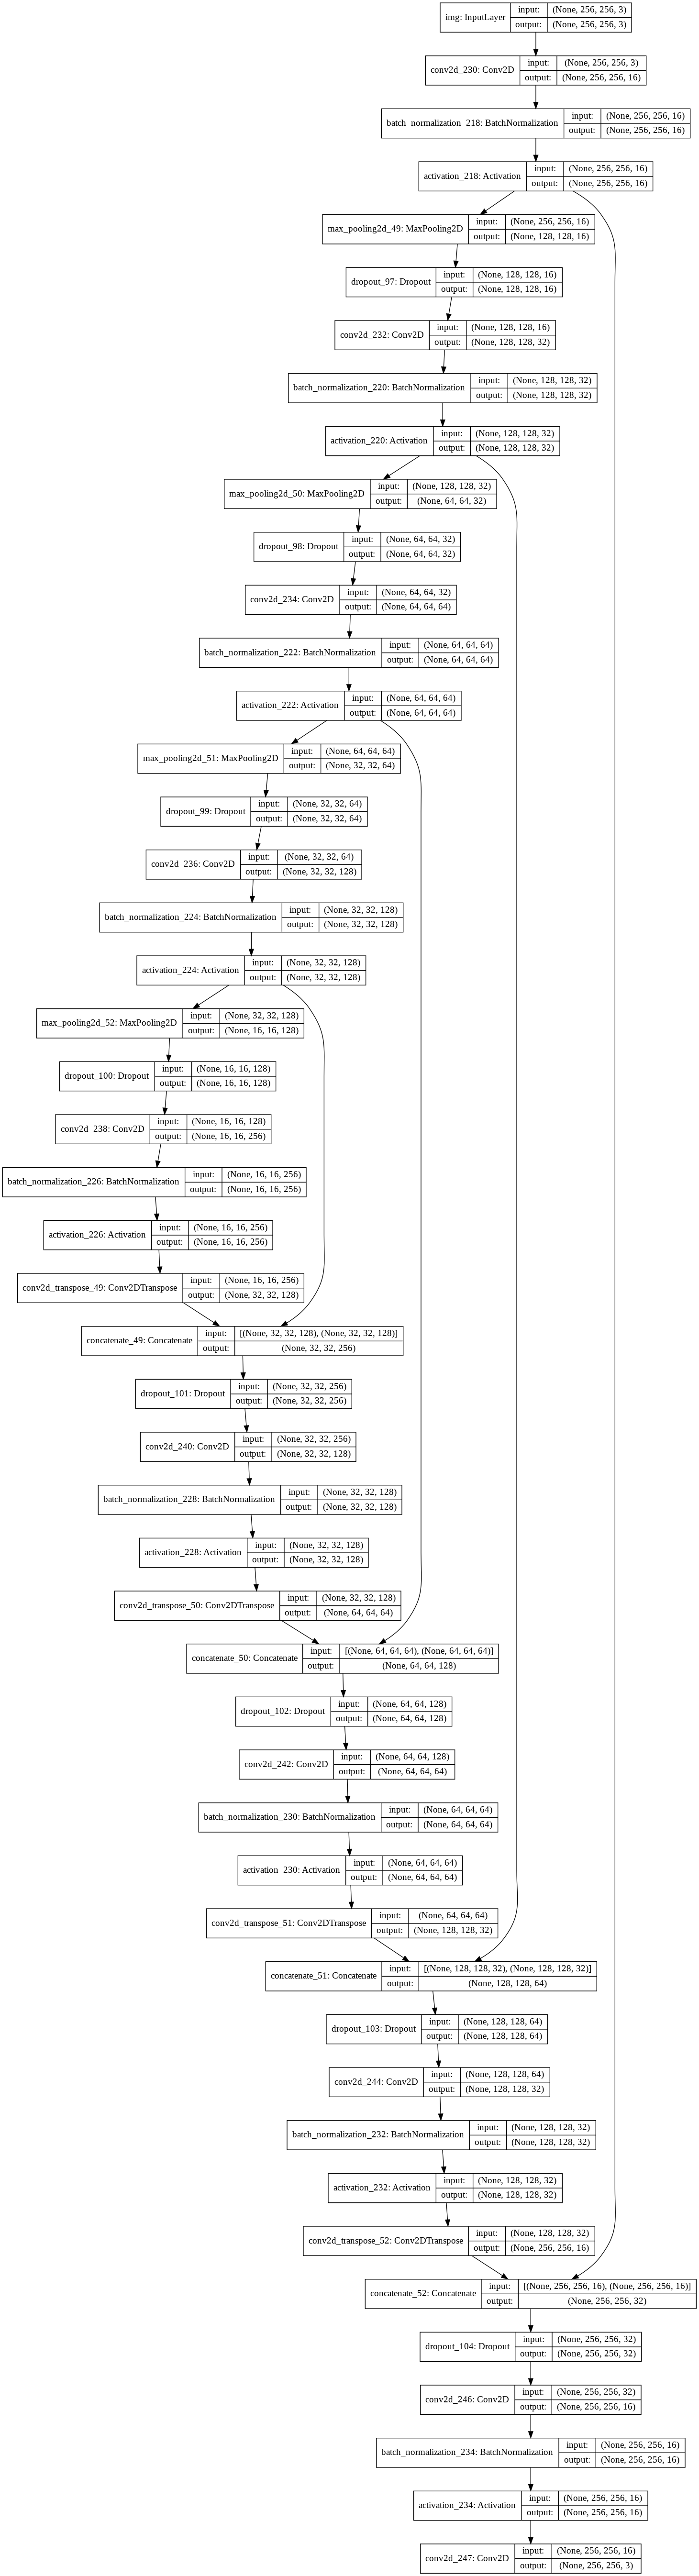

In [276]:
#model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot_unet.png', show_shapes=True, show_layer_names=True)

In [0]:
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    #LearningRateScheduler(lr_scheduler, verbose=1),
    CyclicLR(base_lr=0.0001, max_lr=0.000001, mode='triangular',
                   step_size= 8 * (X_train.shape[0] // 64)),
    ModelCheckpoint('model-monuseg-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

<h1> Train Model </h1>

In [278]:
results = model.fit(X_train, y_train, batch_size=64, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 1080 samples, validate on 101 samples
Epoch 1/100
 128/1080 [==>...........................] - ETA: 28s - loss: 0.8472 - acc: 0.4141 - dice_coef: 0.5954 - f1_score: 0.4326

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.451950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1080/1080 [==============================] - 12s 11ms/step - loss: 0.8162 - acc: 0.4406 - dice_coef: 0.6053 - f1_score: 0.4520 - val_loss: 0.8147 - val_acc: 0.4173 - val_dice_coef: 0.5852 - val_f1_score: 0.3898

Epoch 00001: val_loss improved from inf to 0.81467, saving model to model-monuseg-unet.h5
Epoch 2/100
1080/1080 [==============================] - 7s 6ms/step - loss: 0.7490 - acc: 0.5057 - dice_coef: 0.6289 - f1_score: 0.4906 - val_loss: 0.7849 - val_acc: 0.4912 - val_dice_coef: 0.6051 - val_f1_score: 0.4276

Epoch 00002: val_loss improved from 0.81467 to 0.78493, saving model to model-monuseg-unet.h5
Epoch 3/100
1080/1080 [==============================] - 7s 6ms/step - loss: 0.6927 - acc: 0.5737 - dice_coef: 0.6510 - f1_score: 0.5277 - val_loss: 0.7569 - val_acc: 0.5434 - val_dice_coef: 0.6202 - val_f1_score: 0.4588

Epoch 00003: val_loss improved from 0.78493 to 0.75691, saving model to model-monuseg-unet.h5
Epoch 4/100
1080/1080 [==============================] - 7s 6ms/st

<h1> Performance Graphs </h1>

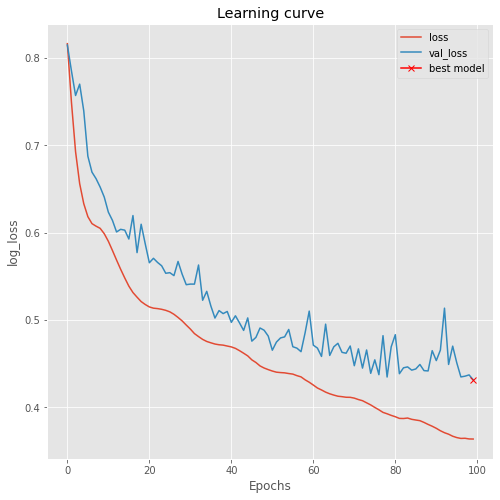

In [279]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

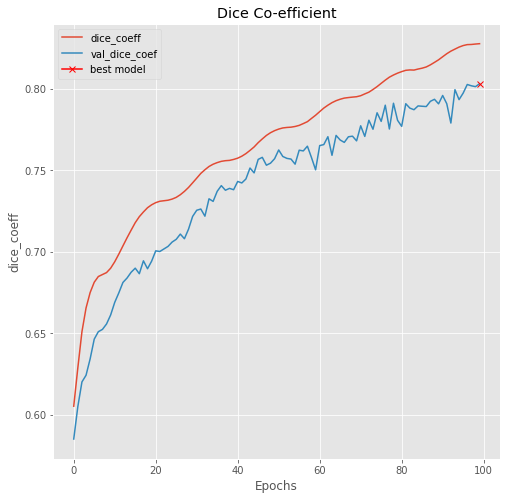

In [281]:
plt.figure(figsize=(8, 8))
plt.title("Dice Co-efficient")
plt.plot(results.history['dice_coef'], label="dice_coeff")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coeff")
plt.legend();

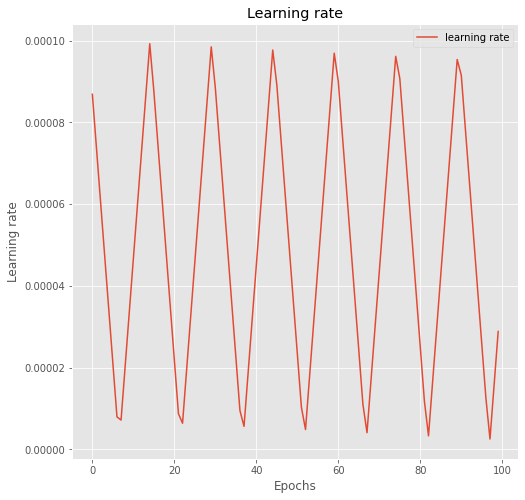

In [282]:
plt.figure(figsize=(8, 8))
plt.title("Learning rate")
plt.plot(results.history["lr"], label="learning rate")
#plt.plot(results.history["val_loss"], label="val_loss")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend();

In [0]:
# load the best model
model.load_weights('model-monuseg-unet.h5')

In [0]:
#unzipping here in colab session
#!unzip '/content/drive/My Drive/MonuSeg-20200317T123814Z-001.zip'

<b>Load Test Data</b>

In [285]:
"""
ids_test = next(os.walk("./MonuSeg/Test/TissueImages"))[2]
print("No. of images in testing set = ", len(ids_test))

#test
XX_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)
yy_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)

#test

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("MonuSeg/Test/TissueImages/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d[0] = d[0]+"_bin_mask."
    id_ = d[0]+"png"
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Test/GroundTruth/"+id_))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    XX_test[n] = x_img/255.0
    yy_test[n] = mask/255.0

"""

'\nids_test = next(os.walk("./MonuSeg/Test/TissueImages"))[2]\nprint("No. of images in testing set = ", len(ids_test))\n\n#test\nXX_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)\nyy_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)\n\n#test\n\n# tqdm is used to display the progress bar\nfor n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):\n    # Load images\n    img = load_img("MonuSeg/Test/TissueImages/"+id_)\n    x_img = img_to_array(img)\n    x_img = resize(x_img, (im_width, im_height, depth), mode = \'constant\', preserve_range = True)\n    \n    #rename mask\n    d = id_.split(\'.\')\n    d[0] = d[0]+"_bin_mask."\n    id_ = d[0]+"png"\n    #print(id_)\n    #renamed becuase GT in filenames include _bin_mask in names\n    \n    # Load masks\n    mask = img_to_array(load_img("MonuSeg/Test/GroundTruth/"+id_))\n    mask = resize(mask, (im_width, im_height, depth), mode = \'constant\', preserve_range = True)

In [286]:
# Evaluate on validation set (this must be equals to the best log_loss)
eval = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss: "+str(eval[0]))
print("Test Accuracy: "+str(eval[1]))
print("Dice co-efficient: "+str(eval[2]))
print("F1-score: "+str(eval[3]))

403/403 [==============================] - 1s 3ms/step
Test Loss: 0.42978010276706874
Test Accuracy: 0.8665722351216205
Dice co-efficient: 0.8034556142745479
F1-score: 0.7157416380664551


<h1> Some Predictions </h1>

In [287]:
# Predict on train, val and test
preds_test = model.predict(X_test, verbose=1)

403/403 [==============================] - 4s 9ms/step


In [0]:
# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 1], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix, ..., 1].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix, ..., 1].squeeze())
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix, ..., 1].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix, ..., 1].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix, ..., 1].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix, ..., 1].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

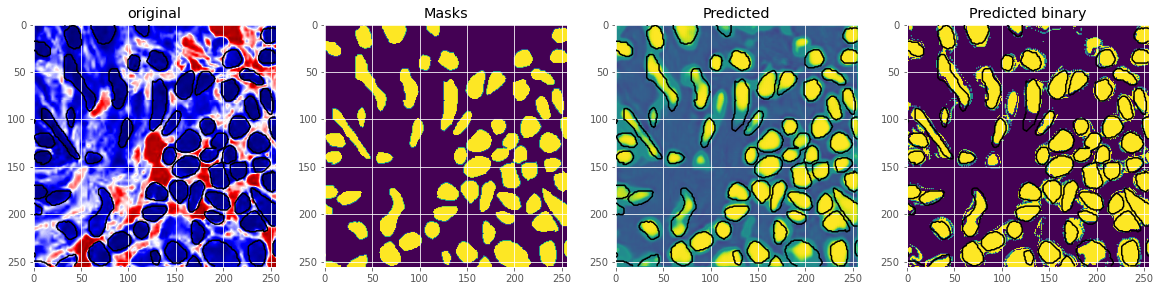

In [290]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=12)

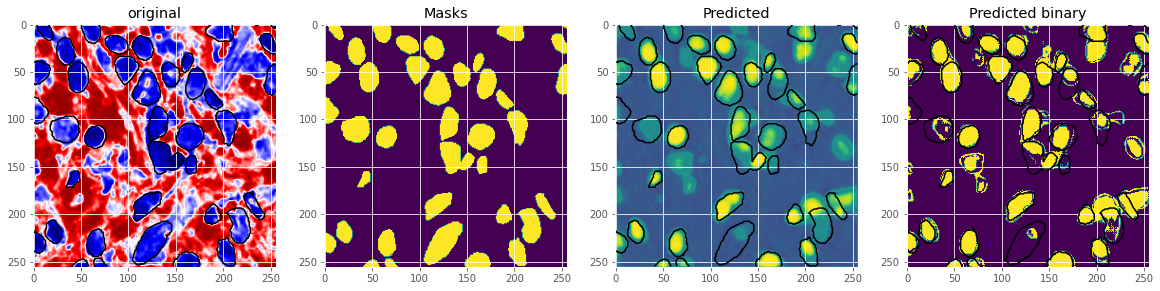

In [295]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=51)

In [292]:
new_ids_test = next(os.walk("./MonuSeg/Test/TissueImages"))[2]
print("No. of images in testing set = ", len(new_ids_test))

#test
XX_test = np.zeros((len(new_ids_test), im_height, im_width, depth), dtype=np.float32)
yy_test = np.zeros((len(new_ids_test), im_height, im_width, depth), dtype=np.float32)

#test

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(new_ids_test), total=len(new_ids_test)):
    # Load images
    img = load_img("MonuSeg/Test/TissueImages/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d[0] = d[0]+"_bin_mask."
    id_ = d[0]+"png"
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Test/GroundTruth/"+id_))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    XX_test[n] = x_img/255.0
    yy_test[n] = mask/255.0

No. of images in testing set =  14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


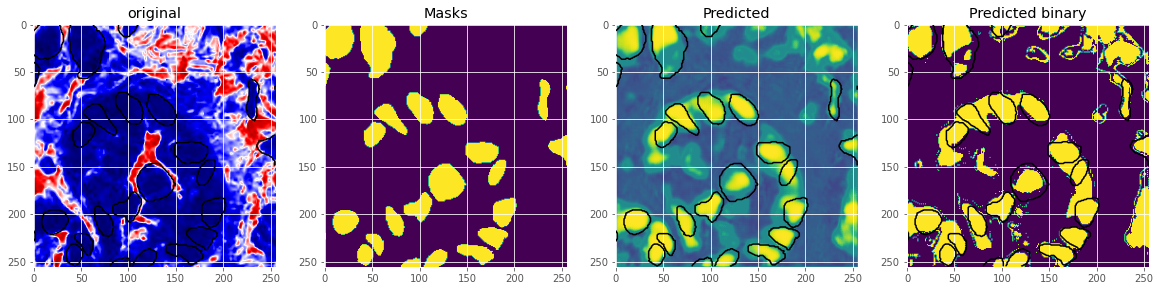

In [294]:
#prediction on test set
# Check if test data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=1)